In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import rpy2.robjects as robj
import pyreadr
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
import sys
import time as Time
import pickle
from scipy.io import loadmat
from scipy.signal import decimate, detrend
import seaborn as sns
%matplotlib inline

In [2]:
sys.path.append("/home/huaqingj/MyResearch/dynamicR2py")
from utils import *

In [3]:
MEG = loadmat("./data/subj1.mat")["DK_timecourse"]

In [4]:
#Rate when doing decimate 
rate = 10 
#MEG = detrend(MEG) # The data are already detrended
MEG = decimate(MEG, q=rate)

## Detection when r=6

In [5]:
kappa = 2.65
r = 6
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

In [12]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [48]:
MEG1Res = edict()
MEG1Res.PostMEG = MEG
MEG1Res.midRes = midRes
MEG1Res.finalRes = finalRes
MEG1Res.Amat = Amat
MEG1Res.dXmat = dXmat
MEG1Res.Xmat = Xmat
paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}
MEG1Res.paras = paras

In [49]:
with open("./results/MEG1Res.pkl", "wb") as f:
    pickle.dump(MEG1Res, f)

In [6]:
with open("./results/MEG1Res.pkl", "rb") as f:
    MEG1Res = pickle.load(f)

In [7]:
MEG1Res.finalRes.mbic_ecpts.shape

(12,)

### Draw the change points curve

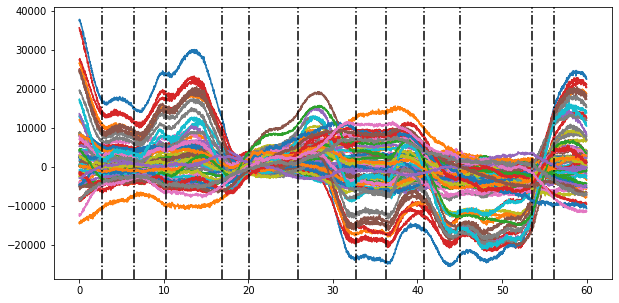

In [8]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in MEG1Res.finalRes.mbic_ecpts:
    plt.axvline(ecpt/60, color="black", linestyle="-.")

### Plot the Reconstructed Curve

In [15]:
finalRes = MEG1Res.finalRes
midRes = MEG1Res.midRes
t0 = Time()
tStep = np.diff(time)[0]
ecpts = finalRes.mbic_ecpts
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(ecpts, ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 27.12s.


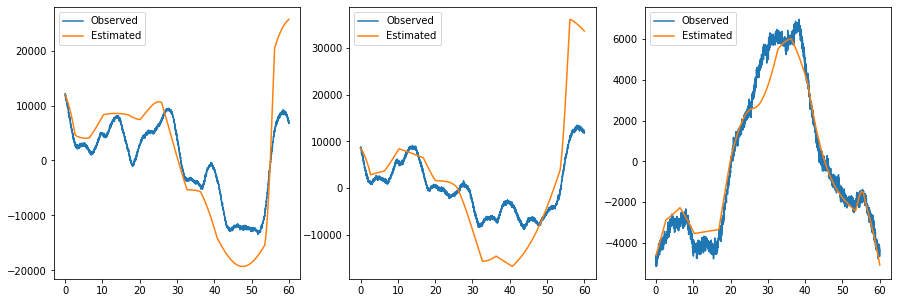

In [16]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
#plt.plot(ptime, MEG[66, :], label="Observed")
#plt.plot(ptime, RecMEG[66, :], label="Estimated")
plt.plot(ptime, MEG[1, :], label="Observed")
plt.plot(ptime, RecMEG[1, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEG[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEG[52, :], label="Estimated")
_ = plt.legend()

In [40]:
freq = 60 
ReLamMs = RecRes.LamMs.real*freq/30 
ImLamMs = RecRes.LamMs.imag*freq /(30*2*np.pi)

In [75]:
linestyles = [  ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))] 
cols = sns.color_palette("Paired", 6)
#cols = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

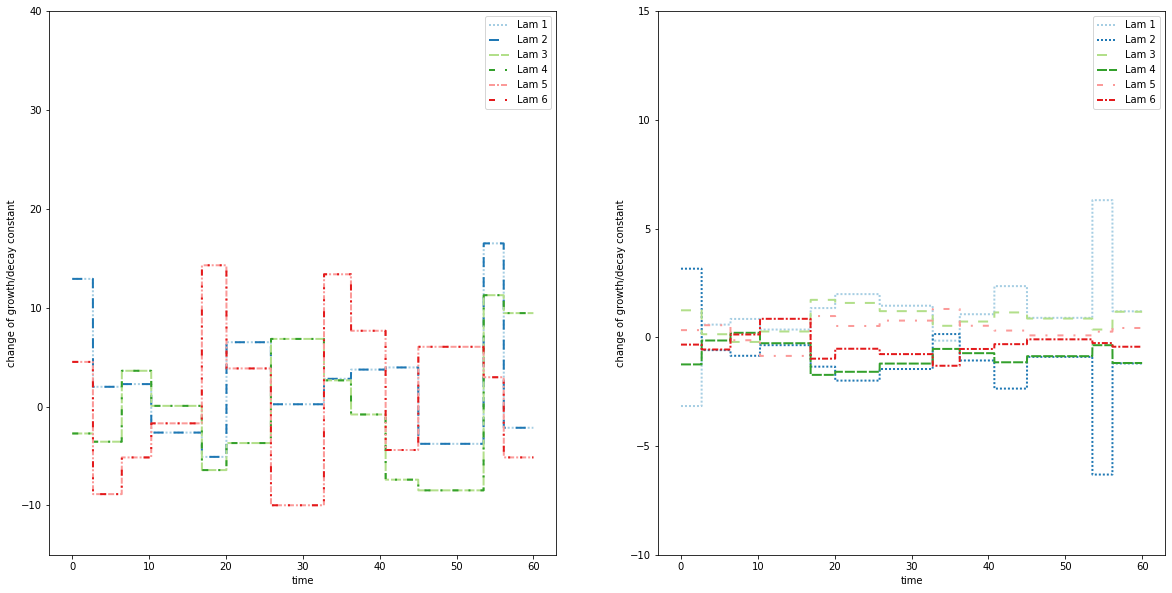

In [78]:
plt.figure(figsize=[20,10])

plt.subplot(121)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ReLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i+1][-1], color=cols[i], linewidth=2)
plt.ylim([-15, 40])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

plt.subplot(122)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ImLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i][-1], color=cols[i], linewidth=2)
plt.ylim([-10, 15])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

### Kappa tuning

In [15]:
kappas = np.linspace(2.5, 3, 100)

In [16]:
U0 = MEG1Res.finalRes.U0

In [18]:
U0s = []
for kappac in kappas:
    U0s.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))

In [20]:
U0s = np.array(U0s)

In [25]:
numchgs = U0s.argmin(axis=1)

Text(0.5, 0, 'kappa')

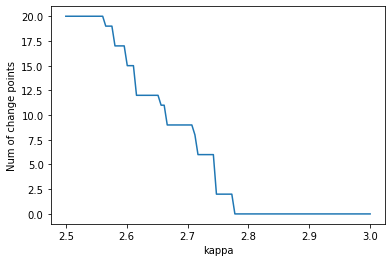

In [27]:
plt.plot(kappas, numchgs)
plt.ylabel("Num of change points")
_ = plt.xlabel("kappa")

In [28]:
numchgs

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 17,
       17, 17, 17, 15, 15, 15, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  6,  6,  6,  6,  6,  6,  2,  2,
        2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [29]:
kappas[numchgs==11]

array([2.65656566, 2.66161616])

### Draw the change points curve when number of change point is 11

In [30]:
ecpts_11 = MEG1Res.finalRes.chgMat[10, :11]

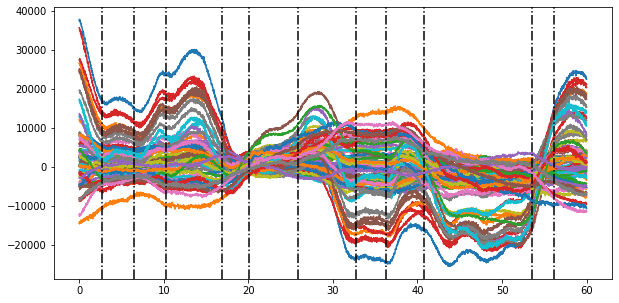

In [33]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in ecpts_11:
    plt.axvline(ecpt/60, color="black", linestyle="-.")

In [35]:
finalRes = MEG1Res.finalRes
midRes = MEG1Res.midRes
t0 = Time()
tStep = np.diff(time)[0]
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes_11 = ReconXmat(ecpts_11, ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, is_full=True) 
RecMEG_11 = RecRes_11.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 93.80s.


### Draw the reconstructed curve when number of change point is 11

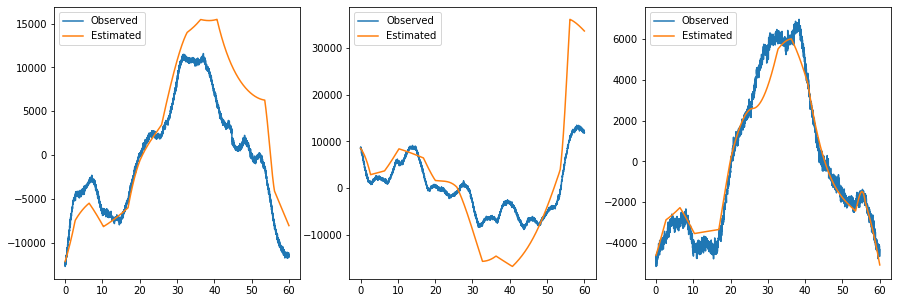

In [36]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[66, :], label="Observed")
plt.plot(ptime, RecMEG_11[66, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEG_11[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEG_11[52, :], label="Estimated")
_ = plt.legend()

In [39]:
[np.mean((MEG-RecMEG_11)**2), np.mean((MEG-RecMEG)**2)]

[47281953.37578041, 48642171.96446022]

## Change the rank of Amat  when rank=4

In [17]:
kappa = 2.65
r = 4
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

In [18]:
print(paras)

{'kappa': 2.65, 'Lmin': 60, 'r': 4, 'downrate': 20, 'MaxM': 19, 'lamb': 0.0001, 'rate': 10}


In [46]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [47]:
MEG1ResRank4 = edict()
MEG1ResRank4.PostMEG = MEG
MEG1ResRank4.midRes = midRes
MEG1ResRank4.finalRes = finalRes
MEG1ResRank4.Amat = Amat
MEG1ResRank4.dXmat = dXmat
MEG1ResRank4.Xmat = Xmat
MEG1Res.paras = paras

In [48]:
with open("./results/MEG1ResRank4.pkl", "wb") as f:
    pickle.dump(MEG1ResRank4, f)

In [19]:
with open("./results/MEG1ResRank4.pkl", "rb") as f:
    MEG1ResRank4 = pickle.load(f)

In [20]:
finalRes = MEG1ResRank4.finalRes
midRes = MEG1ResRank4.midRes
t0 = Time()
tStep = np.diff(time)[0]
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(finalRes.chgMat[10, :11], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 27.13s.


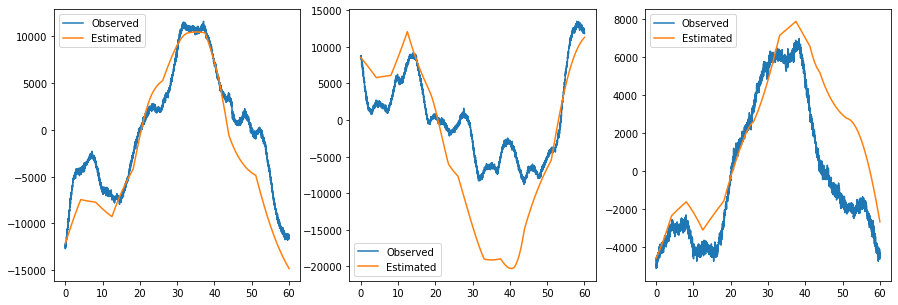

In [21]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[66, :], label="Observed")
plt.plot(ptime, RecMEG[66, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[47, :], label="Observed")
plt.plot(ptime, RecMEG[47, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[52, :], label="Observed")
plt.plot(ptime, RecMEG[52, :], label="Estimated")
_ = plt.legend()

## Change the rank of Amat  when rank=8

In [51]:
kappa = 2.65
r = 8
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

In [52]:
print(paras)

{'kappa': 2.65, 'Lmin': 60, 'r': 8, 'downrate': 20, 'MaxM': 19, 'lamb': 0.0001, 'rate': 10}


In [53]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [54]:
MEG1ResRank8 = edict()
MEG1ResRank8.PostMEG = MEG
MEG1ResRank8.midRes = midRes
MEG1ResRank8.finalRes = finalRes
MEG1ResRank8.Amat = Amat
MEG1ResRank8.dXmat = dXmat
MEG1ResRank8.Xmat = Xmat
MEG1Res.paras = paras

In [55]:
with open("./results/MEG1ResRank8.pkl", "wb") as f:
    pickle.dump(MEG1ResRank8, f)

In [60]:
MEG1Res.midRes.eigVals

array([ 7.96464675e+01+9.27170559e+02j,  7.96464675e+01-9.27170559e+02j,
       -1.64716671e+02+3.89884731e+02j, -1.64716671e+02-3.89884731e+02j,
        1.13330829e+01+4.82542672e+01j,  1.13330829e+01-4.82542672e+01j,
        4.53040692e+01+0.00000000e+00j, -7.95909192e+00+2.94215454e+01j,
       -7.95909192e+00-2.94215454e+01j, -3.32544881e+00+4.13246898e-01j,
       -3.32544881e+00-4.13246898e-01j,  1.65958413e+00+5.46805786e-01j,
        1.65958413e+00-5.46805786e-01j,  4.08698081e-01+9.96876826e-01j,
        4.08698081e-01-9.96876826e-01j, -6.60521758e-01+1.09707428e-01j,
       -6.60521758e-01-1.09707428e-01j,  1.08968076e-01+6.17362131e-01j,
        1.08968076e-01-6.17362131e-01j, -9.68664722e-02+1.61463140e-01j,
       -9.68664722e-02-1.61463140e-01j, -7.21103124e-03+1.37944558e-01j,
       -7.21103124e-03-1.37944558e-01j,  3.46270898e-02+1.22736746e-01j,
        3.46270898e-02-1.22736746e-01j,  7.88370366e-02+0.00000000e+00j,
       -2.11375702e-02+1.47667181e-02j, -2.11375702